In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.segmentation import flood
from os import path
import os
from skimage import io
import ipywidgets as widgets
import glob
from matplotlib.widgets import LassoSelector
from matplotlib.path import Path

__all__ = [
    'zoom_factory',
    'panhandler',
    'image_segmenter'
]
def zoom_factory(ax,base_scale = 1.1):
    """
    parameters
    ----------
    ax : matplotlib axes object
        axis on which to implement scroll to zoom
    base_scale : float
        how much zoom on each tick of scroll wheel
 
    returns
    -------
    disconnect_zoom : function
        call this to disconnect the scroll listener
    """
    def limits_to_range(lim):
        return lim[1] - lim[0]
    
    fig = ax.get_figure() # get the figure of interest
    toolbar = fig.canvas.toolbar
    toolbar.push_current()
    orig_xlim = ax.get_xlim()
    orig_ylim = ax.get_ylim()
    orig_yrange = limits_to_range(orig_ylim)
    orig_xrange = limits_to_range(orig_xlim)
    orig_center = ((orig_xlim[0]+orig_xlim[1])/2, (orig_ylim[0]+orig_ylim[1])/2)

    def zoom_fun(event):
        # get the current x and y limits
        cur_xlim = ax.get_xlim()
        cur_ylim = ax.get_ylim()
        # set the range
        cur_xrange = (cur_xlim[1] - cur_xlim[0])*.5
        cur_yrange = (cur_ylim[1] - cur_ylim[0])*.5
        xdata = event.xdata # get event x location
        ydata = event.ydata # get event y location
        if event.button == 'up':
            # deal with zoom in
            scale_factor = base_scale
        elif event.button == 'down':
            # deal with zoom out
#             if orig_xlim[0]<cur_xlim[0] 
            scale_factor = 1/base_scale
        else:
            # deal with something that should never happen
            scale_factor = 1
#             print(event.button)
        # set new limits
        new_xlim = [xdata - (xdata-cur_xlim[0]) / scale_factor,
                     xdata + (cur_xlim[1]-xdata) / scale_factor]
        new_ylim = [ydata - (ydata-cur_ylim[0]) / scale_factor,
                         ydata + (cur_ylim[1]-ydata) / scale_factor]
        new_yrange = limits_to_range(new_ylim)
        new_xrange = limits_to_range(new_xlim)

        if np.abs(new_yrange)>np.abs(orig_yrange):
            new_ylim = orig_center[1] -new_yrange/2 , orig_center[1] +new_yrange/2
        if np.abs(new_xrange)>np.abs(orig_xrange):
            new_xlim = orig_center[0] -new_xrange/2 , orig_center[0] +new_xrange/2
        ax.set_xlim(new_xlim)
        ax.set_ylim(new_ylim)

        toolbar.push_current()
        ax.figure.canvas.draw_idle() # force re-draw


    # attach the call back
    cid = fig.canvas.mpl_connect('scroll_event',zoom_fun)
    def disconnect_zoom():
        fig.canvas.mpl_disconnect(cid)    

    #return the disconnect function
    return disconnect_zoom

class panhandler:
    """
    enable right click to pan image
    this doesn't set up the eventlisteners, whatever calls this needs to do
    fig.mpl_connect('button_press_event', panhandler.press)
    fig.mpl_connect('button_release_event', panhandler.release)
    
    or somehitng 
    """
    def __init__(self, figure):
        self.figure = figure
        self._id_drag = None

    def _cancel_action(self):
        self._xypress = []
        if self._id_drag:
            self.figure.canvas.mpl_disconnect(self._id_drag)
            self._id_drag = None
        
    def press(self, event):
        if event.button == 1:
            return
        elif event.button == 3:
            self._button_pressed = 1
        else:
            self._cancel_action()
            return

        x, y = event.x, event.y

        self._xypress = []
        for i, a in enumerate(self.figure.get_axes()):
            if (x is not None and y is not None and a.in_axes(event) and
                    a.get_navigate() and a.can_pan()):
                a.start_pan(x, y, event.button)
                self._xypress.append((a, i))
                self._id_drag = self.figure.canvas.mpl_connect(
                    'motion_notify_event', self._mouse_move)
    def release(self, event):
        self._cancel_action()
        self.figure.canvas.mpl_disconnect(self._id_drag)


        for a, _ind in self._xypress:
            a.end_pan()
        if not self._xypress:
            self._cancel_action()
            return
        self._cancel_action()

    def _mouse_move(self, event):
        for a, _ind in self._xypress:
            # safer to use the recorded button at the _press than current
            # button: # multiple button can get pressed during motion...
            a.drag_pan(1, event.key, event.x, event.y)
        self.figure.canvas.draw_idle()


VALID_IMAGE_TYPES = ['jpeg', 'png', 'bmp', 'gif', 'jpg'] # same as supported by keras



class image_segmenter:
    def __init__(self, img_dir, classes, overlay_alpha=.5,figsize=(10,10), scroll_to_zoom=True, zoom_scale=1.1):
        """
        TODO allow for intializing with a shape instead of an image
        
        parameters
        ----------
        img_dir : string
            path to directory 'images' that contains 'train/' and images are in 'train/'
        classes : Int or list
            Number of classes or a list of class names
        ensure_rgba : boolean
            whether to force the displayed image to have an alpha channel to enable transparent overlay
        zoom_scale : float or None
            How much to scale the image per scroll. If you do this I recommend using jupyterlab-sidecar in order
            to prevent the page from scrolling. or checking in on: https://github.com/matplotlib/ipympl/issues/222
            To disable zoom set this to None.
        """

        self.img_dir = img_dir

        if not path.isdir(path.join(self.img_dir, 'train')):
            raise ValueError(f"{self.img_dir} must exist and contain the the folder 'train'")
        self.img_dir = path.join(self.img_dir, 'train')
        #ensure that there is a sibling directory named masks
        self.mask_dir = path.join(self.img_dir.rsplit('train_imgs/',1)[0], 'train_masks/train')
#         self.mask_dir = path.join(self.img_dir.rslit(, 'masks/train/')
        if not os.path.isdir(self.mask_dir):
            os.makedirs(self.mask_dir)
#         elif not os.path.isdir(self.mask_dir):
#             raise ValueError(f'{self.mask_dir} already exists and is not a folder')

        self.image_paths = []
        for type_ in VALID_IMAGE_TYPES:
            self.image_paths += (glob.glob(self.img_dir.rstrip('/')+f'/*.{type_}'))
        self.shape = None        
        
        plt.ioff() # see https://github.com/matplotlib/matplotlib/issues/17013
        self.fig = plt.figure(figsize=figsize)
        self.ax = self.fig.gca()
        lineprops = {'color': 'black', 'linewidth': 1, 'alpha': 0.8}
        self.lasso = LassoSelector(self.ax, self.onselect, lineprops=lineprops, button=1,useblit=False)
        self.lasso.set_visible(True)
        self.fig.canvas.mpl_connect('button_press_event', self.onclick)
        self.fig.canvas.mpl_connect('button_release_event', self._release)
        self.panhandler = panhandler(self.fig)

        # setup lasso stuff
        

        plt.ion()
        
        if isinstance(classes, int):
            classes = np.arange(classes)
        if len(classes)<=10:
            self.colors = 'tab10'
        elif len(classes)<=20:
            self.colors = 'tab20'
        else:
            raise ValueError(f'Currently only up to 20 classes are supported, you tried to use {len(classes)} classes')
        
        self.colors = np.vstack([[0,0,0],plt.get_cmap(self.colors)(np.arange(len(classes)))[:,:3]])
        
        self.class_dropdown = widgets.Dropdown(
                options=[(str(classes[i]), i) for i in range(len(classes))],
                value=0,
                description='Class:',
                disabled=False,
            )
        self.lasso_button = widgets.Button(
            description='lasso select',
            disabled=False,
            button_style='success', # 'success', 'info', 'warning', 'danger' or ''
            icon='mouse-pointer', # (FontAwesome names without the `fa-` prefix)
        )
        self.flood_button = widgets.Button(
            description='flood fill',
            disabled=False,
            button_style='', # 'success', 'info', 'warning', 'danger' or ''
            icon='fill-drip', # (FontAwesome names without the `fa-` prefix)
        )
        
        self.erase_check_box = widgets.Checkbox(
            value=False,
            description='Erase Mode',
            disabled=False,
            indent=False
        )
        
        self.reset_button = widgets.Button(
            description='reset',
            disabled=False,
            button_style='', # 'success', 'info', 'warning', 'danger' or ''
            icon='refresh', # (FontAwesome names without the `fa-` prefix)
        )
        self.save_button = widgets.Button(
            description='save mask',
            button_style='',
            icon='floppy-o'
        )
        self.next_button = widgets.Button(
            description='next image',
            button_style='',
            icon='arrow-right'
        )
        self.prev_button = widgets.Button(
            description='previous image',
            button_style='',
            icon='arrow-left',
            disabled=True
        )
        self.reset_button.on_click(self.reset)
        self.save_button.on_click(self.save_mask)
        self.next_button.on_click(self._change_image_idx)
        self.prev_button.on_click(self._change_image_idx)
        def button_click(button):
            if button.description == 'flood fill':
                self.flood_button.button_style='success'
                self.lasso_button.button_style=''
                self.lasso.set_active(False)
            else:
                self.flood_button.button_style=''
                self.lasso_button.button_style='success'
                self.lasso.set_active(True)
        
        self.lasso_button.on_click(button_click)
        self.flood_button.on_click(button_click)
        self.overlay_alpha = overlay_alpha
        self.indices = None
        self.new_image(0)
        
        #gotta do this after creating the image, and the image needs to come after all the buttons
        if zoom_scale is not None:
            self.disconnect_scroll = zoom_factory(self.ax, base_scale = zoom_scale)

    def _change_image_idx(self, button):
        if button is self.next_button:
            if self.img_idx +1 < len(self.image_paths):
                self.img_idx += 1
                self.save_mask()
                self.new_image(self.img_idx)
                
                if self.img_idx == len(self.image_paths):
                    self.next_button.disabled = True
                self.prev_button.disabled=False
        elif button is self.prev_button:
            if self.img_idx>=1:
                self.img_idx -= 1
                self.save_mask()
                self.new_image(self.img_idx)
                
                if self.img_idx == 0:
                    self.prev_button.disabled=True
                
                self.next_button.disabled=False
            
    def new_image(self, img_idx):
        self.indices=None
        self.img = io.imread(self.image_paths[img_idx])
        self.img_idx = img_idx
        img_path = self.image_paths[self.img_idx]
        self.ax.set_title(os.path.basename(img_path))
        self.mask_path = self.mask_dir + f'/{os.path.basename(img_path)}'
        
        if self.img.shape != self.shape:
            self.shape = self.img.shape
            pix_x = np.arange(self.shape[0])
            pix_y = np.arange(self.shape[1])
            xv, yv = np.meshgrid(pix_y,pix_x)
            self.pix = np.vstack( (xv.flatten(), yv.flatten()) ).T
            self.displayed = self.ax.imshow(self.img)
            #ensure that the _nav_stack is empty
            self.fig.canvas.toolbar._nav_stack.clear()
            #add the initial view to the stack so that the home button works.
            self.fig.canvas.toolbar.push_current()
            if os.path.exists(self.mask_path):
                self.class_mask = io.imread(self.mask_path)
            else:
                self.class_mask = np.zeros([self.shape[0],self.shape[1]],dtype=np.uint8)
        else:
            self.displayed.set_data(self.img)
            if os.path.exists(self.mask_path):
                self.class_mask = io.imread(self.mask_path)
                # should probs check that the first two dimensions are the same as the img
            else:
                self.class_mask[:,:] = 0
            self.fig.canvas.toolbar.home()
        self.updateArray()

        

    def _release(self, event):
        self.panhandler.release(event)

    def reset(self,*args):
        self.displayed.set_data(self.img)
        self.class_mask[:,:] = -1
        self.fig.canvas.draw()

    def onclick(self, event):
        """
        handle clicking to remove already added stuff
        """
        if event.button == 1:
            if event.xdata is not None and not self.lasso.active:
                # transpose x and y bc imshow transposes
                self.indices = flood(self.class_mask,(np.int(event.ydata), np.int(event.xdata)))
                self.updateArray()
        elif event.button == 3:
            self.panhandler.press(event)

    def updateArray(self):
        array = self.displayed.get_array().data

        if self.erase_check_box.value:
            if self.indices is not None:
                self.class_mask[self.indices] = 0
                array[self.indices] = self.img[self.indices]
        elif self.indices is not None:
            self.class_mask[self.indices] = self.class_dropdown.value + 1
            np.save(self.mask_path[:-4]+'npy', self.class_mask)
            # https://en.wikipedia.org/wiki/Alpha_compositing#Straight_versus_premultiplied           
            c_overlay = self.colors[self.class_mask[self.indices]]*255*self.overlay_alpha
            array[self.indices] = (c_overlay + self.img[self.indices]*(1-self.overlay_alpha))
        else:
            # new image and we found a class mask
            # so redraw entire array where class != 0
            idx = self.class_mask != 0
            c_overlay = self.colors[self.class_mask[idx]]*255*self.overlay_alpha
            array[idx] = (c_overlay + self.img[idx]*(1-self.overlay_alpha))
        self.displayed.set_data(array)
        
    def onselect(self,verts):
        self.verts = verts
        p = Path(verts)
        np.save(self.mask_dir+'verts.npy', self.verts)
        self.indices = p.contains_points(self.pix, radius=0).reshape(self.shape[0],self.shape[1]) #.reshape(450,540)
        np.save(self.mask_dir+'inds.npy', self.indices)
        self.updateArray()
        self.fig.canvas.draw_idle()
        
    def render(self):
        layers = [widgets.HBox([self.lasso_button, self.flood_button])]
        layers.append(widgets.HBox([self.reset_button, self.class_dropdown,self.erase_check_box]))
        layers.append(self.fig.canvas)   
        layers.append(widgets.HBox([self.save_button, self.prev_button, self.next_button]))
        return widgets.VBox(layers)
    def save_mask(self, save_if_no_nonzero=False):
        """
        save_if_no_nonzero : boolean
            Whether to save if class_mask only contains 0s
        """
        if (save_if_no_nonzero or np.any(self.class_mask != 0)):
            if os.path.splitext(self.mask_path)[1] in ['jpg', 'jpeg']:
                io.imsave(self.mask_path, self.class_mask,check_contrast =False,quality=100)
            else:
                io.imsave(self.mask_path, self.class_mask,check_contrast =False)
    def _ipython_display_(self):
        display(self.render())

In [13]:
pwd

'/home/jovyan/work'

In [14]:
%matplotlib widget
seg = image_segmenter('samples/',['tool','lung','oesophagus','fatty_tissue', 'dd'], overlay_alpha=.4, zoom_scale=0)



In [15]:
seg

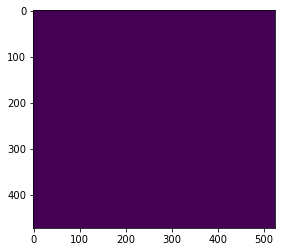

In [11]:
%matplotlib inline
plt.imshow(seg.class_mask)